Data:

aisles.csv: 134 aisle names

departments.csv: 21 department names

order_products__*.csv
These files specify which products were purchased in each order. order_products__prior.csv contains previous order contents for all customers. 'reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items. You may predict an explicit 'None' value for orders with no reordered items.

orders.csv
Orders for each customer. Order_eval is for test-train-split purposes. 'order_dow' is the day of week.

In [58]:
import numpy as np
import pandas as pd
import matplotlib as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')
import os

files = os.listdir('../data/')
files

['aisles.csv',
 'departments.csv',
 'orders.csv',
 'order_products__prior.csv',
 'order_products__train.csv',
 'products.csv',
 'sample_submission.csv']

In [25]:
aisles = pd.read_csv('../data/'+files[0], index_col='aisle_id')
aisles

,aisle
aisle_id,
1,prepared soups salads
2,specialty cheeses
3,energy granola bars
4,instant foods
5,marinades meat preparation
...,...
130,hot cereal pancake mixes
131,dry pasta
132,beauty


In [27]:
departments = pd.read_csv('../data/'+files[1], index_col='department_id')
departments
# missing is a values

,department
department_id,
1,frozen
2,other
3,bakery
4,produce
5,alcohol
6,international
7,beverages
8,pets
9,dry goods pasta


In [52]:
orders = pd.read_csv('../data/'+files[2])
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [33]:
products = pd.read_csv('../data/'+files[4])
products

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


### Missing Values
- Aisles: 0
- Departments: 0 (labelled 'missing')
- Orders: 6% of observations (206209/3421083), NaN indicates no items are re-ordered
- Products: 0 

In [49]:
# Check null and na values
aisles.isnull().sum()
departments.isnull().sum()
products.isnull().sum()
orders.isnull().sum()

# Calculate %items that are new orders
orders.days_since_prior_order.isnull().sum()/orders.shape[0]*100

6.027594185817766

In [43]:
orders.days_since_prior_order.unique()

array([nan, 15., 21., 29., 28., 19., 20., 14.,  0., 30., 10.,  3.,  8.,
       13., 27.,  6.,  9., 12.,  7., 17., 11., 22.,  4.,  5.,  2., 23.,
       26., 25., 16.,  1., 18., 24.])

### Description:
- 206209 customers
- Orders per customer
    - Average order number:  16.6
    - Median order number:  10.0
    - Max order number:  100
    - Min Order number:  4

In [70]:
orders.user_id.nlargest(1)
df = orders.groupby('user_id').order_id.agg('count')

user_id
1         11
2         15
3         13
4          6
5          5
          ..
206205     4
206206    68
206207    17
206208    50
206209    14
Name: order_id, Length: 206209, dtype: int64

Average order number:  16.590367054784224
Median order number:  10.0
Max order number:  100
Min order number:  4


Text(0, 0.5, 'Customer Number')

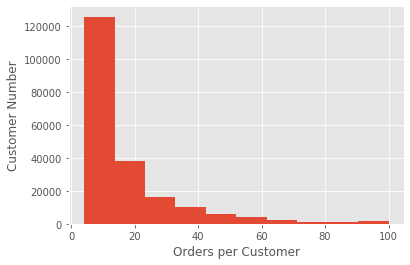

In [74]:
# Most customers place 10 orders
print('Average order number: ', np.mean(df))
print('Median order number: ', np.median(df))
print('Max order number: ', max(df))
print('Min order number: ', min(df))

plt.pyplot.hist(df)
plt.pyplot.xlabel('Orders per Customer')
plt.pyplot.ylabel('Customer Number')

Busiest Day:  600905
Slowest Day:  426339


Text(0, 0.5, 'Number of Orders')

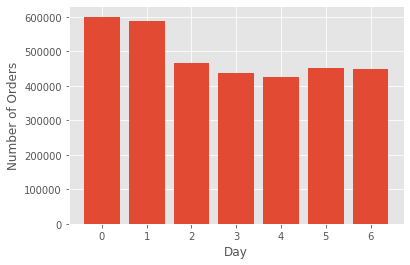

In [82]:
dow = orders.groupby('order_dow').order_id.agg('count')

print('Busiest Day: ', max(dow))
print('Slowest Day: ', min(dow))

plt.pyplot.bar(dow.index, dow)
plt.pyplot.xlabel('Day')
plt.pyplot.ylabel('Number of Orders')



Top 5 Busiest Hours:  order_hour_of_day
10    288418
11    284728
15    283639
14    283042
13    277999
Name: order_id, dtype: int64
Slowest Hour:  order_hour_of_day
3    5474
4    5527
2    7539
5    9569
Name: order_id, dtype: int64


Text(0, 0.5, 'Number of Orders')

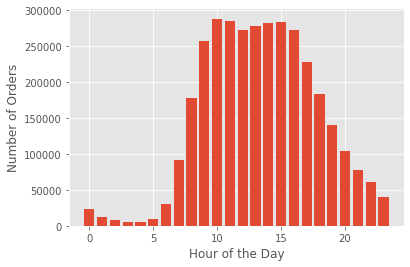

In [90]:
hours = orders.groupby('order_hour_of_day').order_id.agg('count')

print('Top 5 Busiest Hours: ', hours.nlargest(5))
print('Slowest Hour: ', hours.nsmallest(4))

plt.pyplot.bar(hours.index, hours)
plt.pyplot.xlabel('Hour of the Day')
plt.pyplot.ylabel('Number of Orders')

Text(0, 0.5, 'Number of Orders')

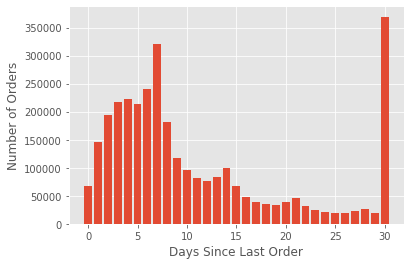

In [91]:
days_since = orders.groupby('days_since_prior_order').order_id.agg('count')

plt.pyplot.bar(days_since.index, days_since)
plt.pyplot.xlabel('Days Since Last Order')
plt.pyplot.ylabel('Number of Orders')

### Conclusions

1. Most customers place 10 orders
2. Day 0-1 (assuming to be Saturday, Sunday) are the days with the most orders
3. Peak ordering time is mid-day 9am-4pm 
4. Most re-orders are placed over a month or one week after the original order